<a href="https://colab.research.google.com/github/jason96819/Studying/blob/main/sklearn/9_Decision_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 결정 트리

트리 기반의 분류와 회귀문제를 해결하는 모델

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
# 분류 평가 지표 함수
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average='micro')
    recall = recall_score(y_test, pred, average='micro')                            # 적절한 average 설정을 사용
    f1 = f1_score(y_test, pred, average='micro')

    roc_auc = None  # 기본적으로 None으로 설정

    if pred_proba is not None:
        roc_auc = roc_auc_score(y_test, pred_proba)

    print('오차행렬')
    print(confusion)
    print('정확도 : {0:.4f}\n정밀도 : {1:.4f}\n재현율 : {2:.4f}\nF1 : {3:.4f}'.format(accuracy, precision, recall, f1))

    if roc_auc is not None:
        print('AUC : {0:.4f}'.format(roc_auc))

## 파라미터 확인

In [3]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [2]:
# 분류 파라미터 확인
dt_clf = DecisionTreeClassifier()
dt_clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [5]:
# 회귀 파라미터 확인
dt_reg = DecisionTreeRegressor()
dt_reg.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

## 분류

In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [43]:
dt_clf = DecisionTreeClassifier(random_state=156)

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((105, 4), (45, 4), (105,), (45,))

In [44]:
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=156)

In [45]:
from sklearn.tree import export_graphviz

export_graphviz(dt_clf, out_file='tree.dot', class_names=iris.target_names,
                feature_names = iris.feature_names, impurity=True, filled=True)

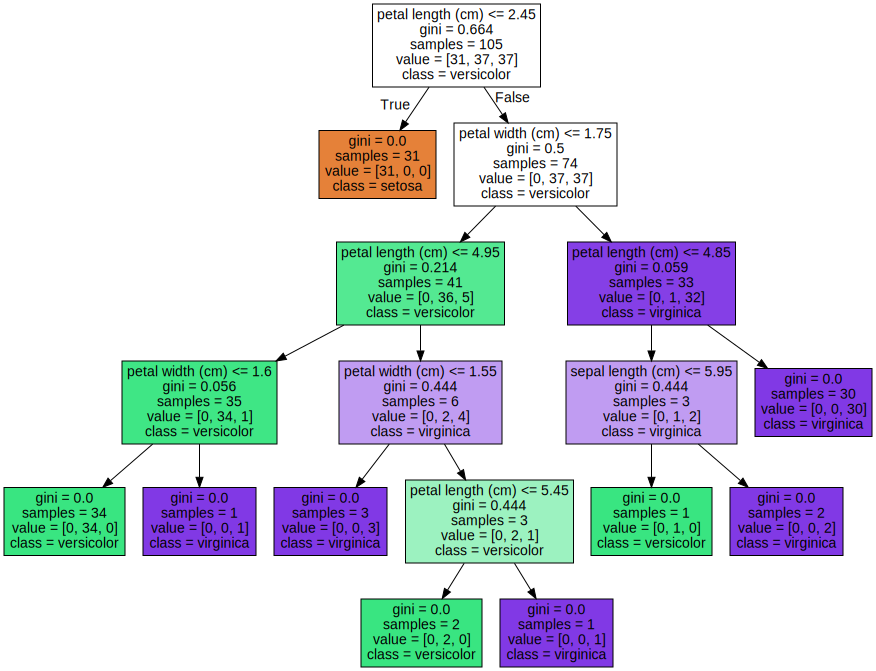

In [46]:
import graphviz

with open('tree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [53]:
pred = dt_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬
[[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]
정확도 : 1.0000
정밀도 : 1.0000
재현율 : 1.0000
F1 : 1.0000


### 하이퍼 파라미터 튜닝

In [13]:
from sklearn.model_selection import GridSearchCV

In [16]:
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None] + list(range(1, 20)),
    'min_samples_split': list(range(2, 10)),
    'min_samples_leaf': list(range(1, 5)),
    'max_features': [None, 'sqrt', 'log2']
}

In [20]:
grid_search = GridSearchCV(estimator=dt_clf, param_grid=params, cv=5, scoring='accuracy')

In [54]:
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 및 성능 출력
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 6}
Best Accuracy: 0.9428571428571428


In [60]:
dt_clf_best_params = grid_search.best_params_
dt_clf = DecisionTreeClassifier(**dt_clf_best_params)

In [61]:
dt_clf.fit(X_train, y_train)
y_pred = dt_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬
[[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]
정확도 : 1.0000
정밀도 : 1.0000
재현율 : 1.0000
F1 : 1.0000


### 중요도

In [62]:
print('피처 중요도 :', np.round(dt_clf.feature_importances_, 4))

피처 중요도 : [0.     0.     0.5595 0.4405]


In [63]:
for name, value in zip(iris.feature_names, dt_clf.feature_importances_):
    print('{0} : {1:.4f}'.format(name, value))

sepal length (cm) : 0.0000
sepal width (cm) : 0.0000
petal length (cm) : 0.5595
petal width (cm) : 0.4405


<Axes: >

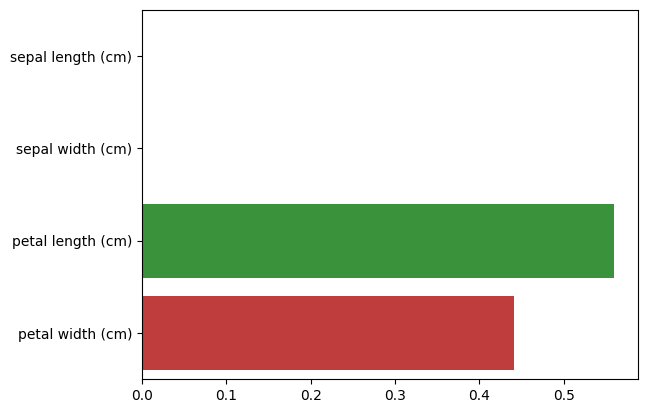

In [64]:
sns.barplot(x=dt_clf.feature_importances_, y=iris.feature_names)

## 회귀

In [67]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import load_diabetes

In [68]:
diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((353, 10), (89, 10), (353,), (89,))

In [69]:
dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train, y_train)

DecisionTreeRegressor()

In [71]:
pred = dt_reg.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred)

In [72]:
print('MSE :', mse)
print('RMSE :', rmse)
print('결정 계수 :', r2)

MSE : 5173.887640449439
RMSE : 71.92974100085054
결정 계수 : 0.02345423724451745


In [74]:
diabetes.keys()

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])

In [75]:
from sklearn.tree import export_graphviz

export_graphviz(dt_reg, out_file='tree.dot', class_names=diabetes.target_filename,
                feature_names = diabetes.feature_names, impurity=True, filled=True)

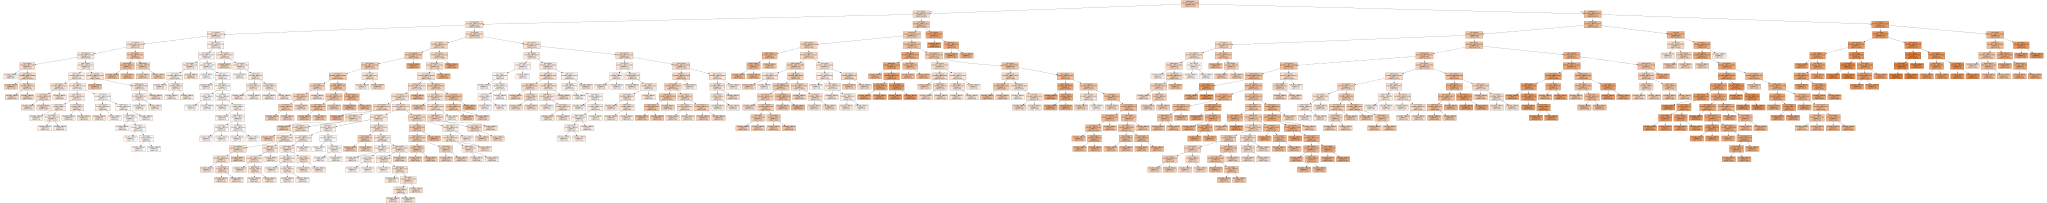

In [76]:
import graphviz

with open('tree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [84]:
diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((353, 10), (89, 10), (353,), (89,))

In [85]:
dt_reg = DecisionTreeRegressor(max_depth=3)
dt_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3)

In [86]:
pred = dt_reg.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred)

In [87]:
print('MSE :', mse)
print('RMSE :', rmse)
print('결정 계수 :', r2)

MSE : 3552.701313323753
RMSE : 59.60454104616319
결정 계수 : 0.3294451571119206


In [89]:
from sklearn.tree import export_graphviz

export_graphviz(dt_reg, out_file='tree.dot', class_names=diabetes.target_filename,
                feature_names = diabetes.feature_names, impurity=True, filled=True)

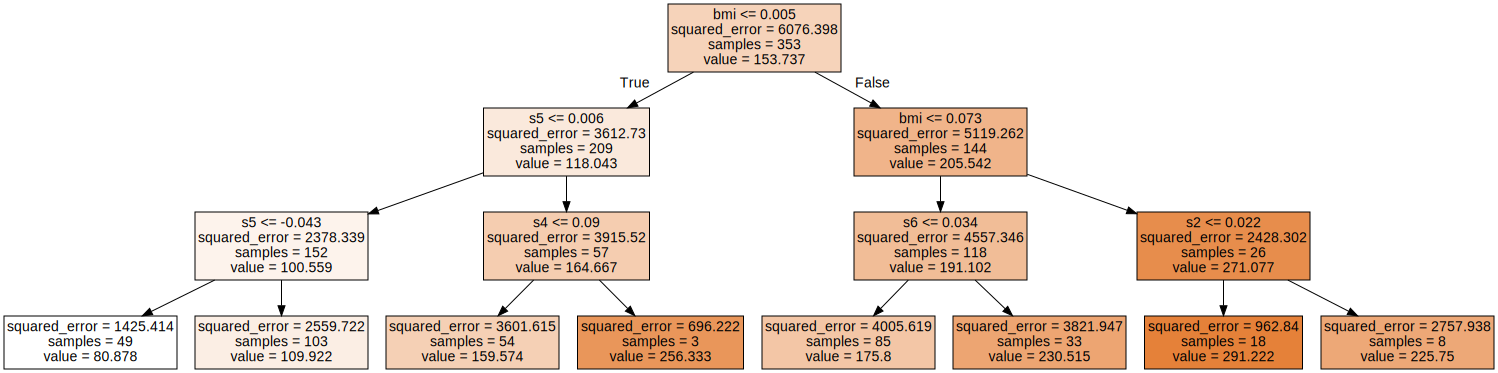

In [90]:
import graphviz

with open('tree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)